# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\srbuc\OneDrive\Desktop\hw1\hw2\hw2-srb289`


In [2]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

Assumptions:
- River is fully mixed after each discharge point
- No dispersion or diffusion
- Complete mixing across cross section of river

Defining variables:

$q_1 = 250,000 m^3/d$

$q_2 = 40,000 m^3/d$

$q_3 = 60,000 m^3/d$

$c_1 = 0.5 kg/(1000 m^3)$

$c_2 = 9 kg/(1000 m^3)$

$c_3 = 7 kg/(1000 m^3)$

$v = 10 km/d$

$k = 0.36 d^{-1}$

x will be defined as 0 at the first mixing point, and 15 at the second


C(x) will be a stepwise function, using the solution to the mass balance differential equation for a PFR with mixing at the start for each section.

$0 \leq x < 15$:


$C(x) = \frac{q_1 \times c_1 + q_2 \times c_2}{q_1 + q_2}e^{-k\frac{x}{v}}$


$15 \leq x$:


$C(x) = \frac{q_1 \times c_1 + q_2 \times c_2}{q_1 + q_2 + q_3}e^{-k\frac{x}{v}} + \frac{q_3 \times c_3}{q_1 + q_2 + q_3}e^{-k\frac{x-15}{v}}$


The concentration will obviously be highest at the mixing points, so we only need to check $C(0)$ and $C(15)$.

By simple arithmetic, we find the concentration $C(0) = 1.67$ and $C(15) = 2.007$.

Both these values are below the regulatory limit, so there is no issue.

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

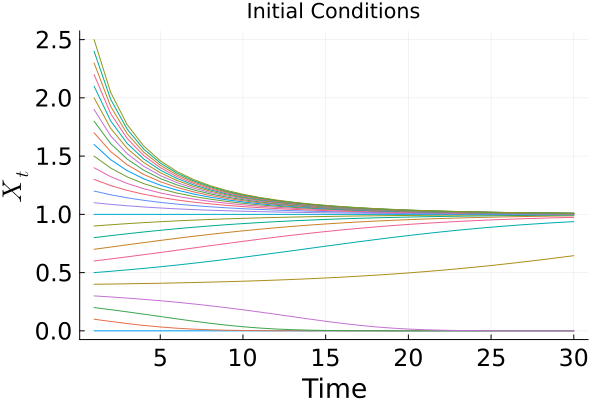

In [15]:
# define functions for lake recycling and outflows
lake_P_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_P_out(x, b) = b .* x;

T = 30
b = 0.5
q = 1.5

X_vals = collect(0.0:0.1:2.5)

function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_P_cycling(X[t-1], q) .- lake_P_out(X[t-1], b)
    end
    return X
end

X = map(x -> simulate_lake_P(x, T, b, q, zeros(T), zeros(T)), X_vals)

p_noinflow = plot(X, label=false, title = "Initial Conditions", ylabel=L"X_t", xlabel="Time", guidefontsize=18, tickfontsize=16)


In [16]:
X_delta(x, a, q, b) = a .+ lake_P_cycling(x,q) .- lake_P_out(x,b)

# Equilibria points
a = 0
e1 = Roots.find_zero(x -> X_delta(x,a,q,b),0)
e2 = Roots.find_zero(x -> X_delta(x,a,q,b),1)
@show(e1,e2)

e1 = 0.0
e2 = 1.0


1.0

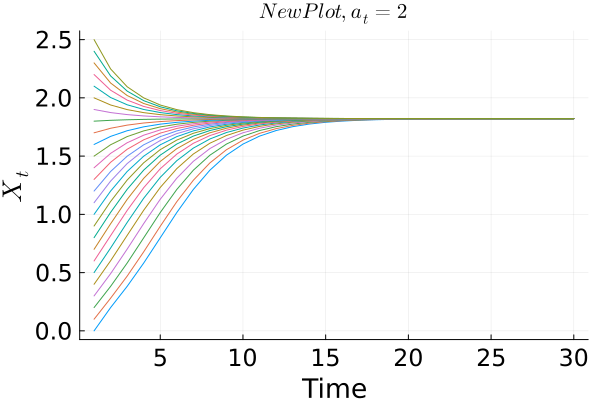

In [17]:
# Replotting with new at value

X = map(x -> simulate_lake_P(x, T, b, q, 0.2.*ones(T), zeros(T)), X_vals)

p_noinflow = plot(X, label=false, title = L"New Plot, a_t=2", ylabel=L"X_t", xlabel="Time", guidefontsize=18, tickfontsize=16)

In [19]:
X_delta(x, a, q, b) = a .+ lake_P_cycling(x,q) .- lake_P_out(x,b)

# Equilibria points
a = .2
e1 = Roots.find_zero(x -> X_delta(x,a,q,b),1.8)
@show(e1)

e1 = 1.821786586216037


1.821786586216037

The original system has equilibria at x = 0 and x = 1. With a = 0.2, the system has one equilibrium point at x = 1.8. For the original system, the equilibrium point at x = 0 had some stability, in that it would slowly return to zero after a dirsuption of up to around 0.3. For anything above that, the system would quickly converge to x = 1, a more stable equilibrium point. In the new system, the lower, more fragile equilibrium point is gone, and the system is very stable at a higher threshold.

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.

Gianna Weidman